In [1]:
import numpy as np
import numpy.random as rnd
from numpy import exp, log
import scipy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import pinvh

from scipy.special import i0
from scipy.special import softmax

from core import *

In [2]:
env = environment(sig_Psi=0.3, sig_s=0.06, sig_obs=0.1)

In [3]:
traj,obs,_ = env.gen_observations(rnd.rand(2,),30000)
traj_feats = env.Psi_fun(traj)
alpha_s, err_s = env.decode_mean(traj, traj_feats)


env.wake_sleep(alpha = alpha_s, Niter=50, eps=1.e-3, tau=1.e-4)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [14:56<00:00, 17.93s/it]


(2, 1000)


[]

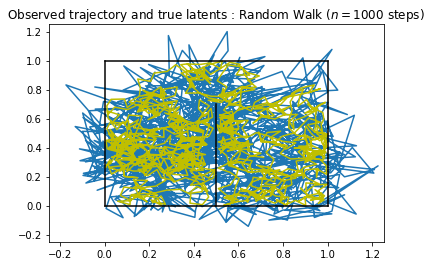

In [4]:
traj,obs,_ = env.gen_observations(rnd.rand(2,),1000)
print(obs.shape)

# plotting observed trajectory and true latents
plt.title("Observed trajectory and true latents : Random Walk ($n = " + str(1000) + "$ steps)") 
plt.plot(obs[0], obs[1]) 
plt.plot(traj[0], traj[1], color = 'y') 
plt.axis([-0.25, 1.25, -0.25, 1.25])
plt.axvline(x=0, ymin=1/6, ymax=5/6, color = 'k')
plt.axvline(x=1, ymin=1/6, ymax=5/6, color = 'k')
plt.axhline(y=0, xmin=1/6, xmax=5/6, color = 'k')
plt.axhline(y=1, xmin=1/6, xmax=5/6, color = 'k')
plt.axvline(x=0.5, ymin=1/6, ymax=(0.7+0.25)/1.5, color = 'k')
plt.plot()

[]

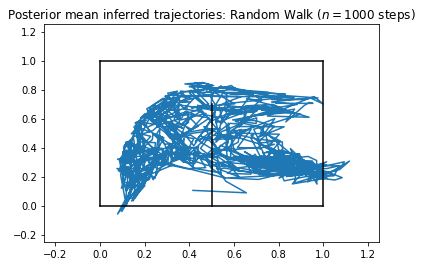

In [5]:
obs_feats = env.Psi_fun(obs)
traj_feats = env.Psi_fun(traj)
mu_feats =  env.run_filter(obs_feats, traj_feats[:,0])
alpha_decode, err_decode = env.decode_mean(traj[:,:-1], mu_feats)
mu = alpha_decode.dot(mu_feats)

plt.title("Posterior mean inferred trajectories: Random Walk ($n = " + str(1000) + "$ steps)") 
plt.plot(mu[0], mu[1]) 
plt.axis([-0.25, 1.25, -0.25, 1.25])
plt.axvline(x=0, ymin=1/6, ymax=5/6, color = 'k')
plt.axvline(x=1, ymin=1/6, ymax=5/6, color = 'k')
plt.axhline(y=0, xmin=1/6, xmax=5/6, color = 'k')
plt.axhline(y=1, xmin=1/6, xmax=5/6, color = 'k')
plt.axvline(x=0.5, ymin=1/6, ymax=(0.7+0.25)/1.5, color = 'k')
plt.plot()

[]

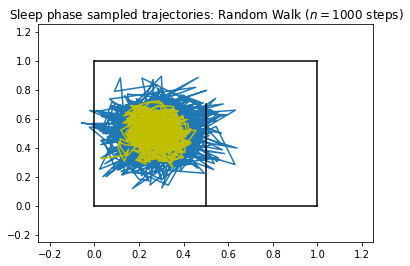

In [6]:
s_sleep, o_sleep = env.gen_sleep_samples_rand_angles(s0=rnd.rand(2,), Tmax=1000, alpha=alpha_s)

# plotting sleep trajectories
plt.title("Sleep phase sampled trajectories: Random Walk ($n = " + str(1000) + "$ steps)") 
plt.plot(o_sleep[0], o_sleep[1])
plt.plot(s_sleep[0], s_sleep[1], color = 'y')
plt.axis([-0.25, 1.25, -0.25, 1.25])
plt.axvline(x=0, ymin=1/6, ymax=5/6, color = 'k')
plt.axvline(x=1, ymin=1/6, ymax=5/6, color = 'k')
plt.axhline(y=0, xmin=1/6, xmax=5/6, color = 'k')
plt.axhline(y=1, xmin=1/6, xmax=5/6, color = 'k')
plt.axvline(x=0.5, ymin=1/6, ymax=(0.7+0.25)/1.5, color = 'k')
plt.plot()

In [7]:
s_sleep, o_sleep = env.gen_sleep_samples_rand_angles(s0=rnd.rand(2,), Tmax=30000, alpha=alpha_s)

#eta is more like learning rate here
m, delta = env.SF_TD_sleep(s_sleep, eta=0.01, gamma=0.99)

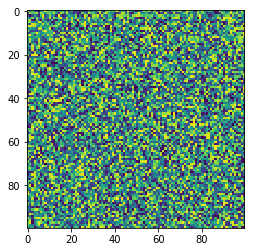

In [8]:
plt.imshow(m)

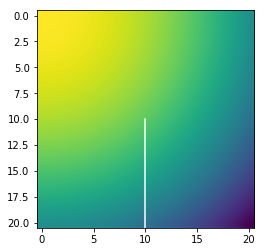

In [9]:
def rew_fun(x,y):
    return 2-(2*x)**2 -(2*y)**2

x = y = np.linspace(0, 1, 21)
z = np.array([rew_fun(i,j) for j in y for i in x])
Z = z.reshape(21, 21)
plt.axvline(x=10, ymin=0, ymax=0.5, color = 'w')
plt.imshow(Z, interpolation='bilinear')

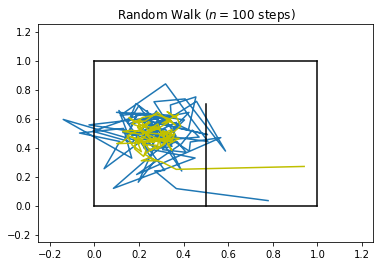

In [10]:
s_sleep, o_sleep = env.gen_sleep_samples_rand_angles(s0=rnd.rand(2,), Tmax=100, alpha=alpha_s)

# plotting observed trajectory and true latents
plt.title("Random Walk ($n = " + str(100) + "$ steps)") 
plt.plot(o_sleep[0], o_sleep[1])
plt.plot(s_sleep[0], s_sleep[1], color = 'y')
plt.axis([-0.25, 1.25, -0.25, 1.25])
plt.axvline(x=0, ymin=1/6, ymax=5/6, color = 'k')
plt.axvline(x=1, ymin=1/6, ymax=5/6, color = 'k')
plt.axhline(y=0, xmin=1/6, xmax=5/6, color = 'k')
plt.axhline(y=1, xmin=1/6, xmax=5/6, color = 'k')
plt.axvline(x=0.5, ymin=1/6, ymax=(0.7+0.25)/1.5, color = 'k')
plt.plot()


Psi_s_sleep = env.Psi_fun(s_sleep)
r = np.array(rew_fun(s_sleep[0], s_sleep[1]))

# ax= b. Solve for x
# Psi_s_sleep . w_s.T = r
w_s = (r.dot(pinvh(Psi_s_sleep))).T

In [11]:
w_obs = env.compute_reward_weights_obs(s_sleep, o_sleep, w_s)

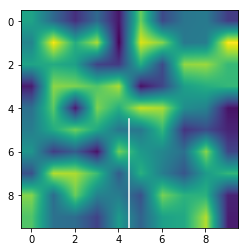

In [12]:
V = w_s.T.dot(m)

V = V.reshape(10,10).T
plt.axvline(x=4.5, ymin=0, ymax=0.5, color = 'w')
plt.imshow(V, interpolation='bilinear')


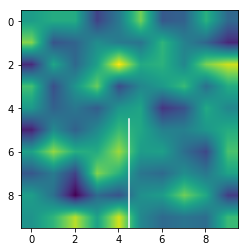

In [13]:
V_obs = w_obs.T.dot(m)

V_obs = V_obs.reshape(10,10).T
plt.axvline(x=4.5, ymin=0, ymax=0.5, color = 'w')
plt.imshow(V_obs, interpolation='bilinear')